In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
datadir = "../data"
savedir = "../saves/catboost"
if not os.path.exists(savedir):
    os.makedirs(savedir)
os.listdir(datadir)
df_train = pd.read_csv(os.path.join(datadir, "single_muts_train.csv"))
df_test = pd.read_csv(os.path.join(datadir, "single_muts_test.csv"))

In [3]:
sorted(set([x for xs in df_test.sequence for x in xs]))
#df_train[['sequence', "stabilityscore"]].values

['A',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'V',
 'W',
 'Y']

In [4]:
aa = """Alanine	Ala	A
Arginine	Arg	R
Asparagine	Asn	N
Aspartic Acid	Asp	D
Cysteine	Cys	C
Glutamic Acid	Glu	E
Glutamine	Gln	Q
Glycine	Gly	G
Histidine	His	H
Isoleucine	Ile	I
Leucine	Leu	L
Lysine	Lys	K
Methionine	Met	M
Phenylalanine	Phe	F
Proline	Pro	P
Serine	Ser	S
Threonine	Thr	T
Tryptophan	Trp	W
Tyrosine	Tyr	Y
Valine	Val	V"""

aadict = dict()
for line in aa.split("\n"):
    data = line.split()
    if len(data)< 3:
        continue
    name = " ".join(data[0:-2])
    l3, l1 = data[-2:]
    aadict[l1] = (name, l3)
aa = sorted(aadict)
aa2idx = {x: i for i, x in enumerate(aa)}

In [9]:
x_full_train = np.stack(df_train.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
y_full_train = df_train.stabilityscore.values

x_full_test = np.stack(df_test.sequence.apply(lambda xs: np.asarray([aa2idx[x] for x in xs])).values)
y_full_test = df_test.stabilityscore.values

In [12]:
print(x_full_train[0])
print(aa2idx)

[ 5 15 15 16 16 14 19 14  4 16  2  3  3  3  0 14 14  0  0  8  3 18  0 14
 14  5 19 13  9  6 17 16 13 11  5 16 19 18  3 17  3 17 14]
{'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}


In [25]:
def calc_buriedArea(seq):
    'Values taken from https://web.expasy.org/protscale/pscale/Averageburied.html'
    dict={
        0:86.600,
        1:132.300,
        2:97.800,
        3:113.900,
        4:194.100,
        5:62.900,
        6:155.800,
        7:158.000,
        8:115.500,
        9:164.100,
        10:172.900,
        11:103.300,
        12:92.900,
        13:119.200,
        14:162.200,
        15:85.600,
        16:106.500,
        17:141.000,
        18:224.600,
        19:177.700
    }
    buried_area=0.0
    for i in seq:
        buried_area+=dict[i]
    
    return(buried_area)



In [17]:
calc_buriedArea(x_full_train[0])

5531.899999999999

In [18]:
buriedAreas=[calc_buriedArea(x) for x in x_full_train]

In [21]:
import matplotlib.pyplot as plt

(array([ 131.,  560., 1003., 1487., 1800., 1736., 1096.,  515.,  193.,
          29.]),
 array([5013.7 , 5079.38, 5145.06, 5210.74, 5276.42, 5342.1 , 5407.78,
        5473.46, 5539.14, 5604.82, 5670.5 ]),
 <a list of 10 Patch objects>)

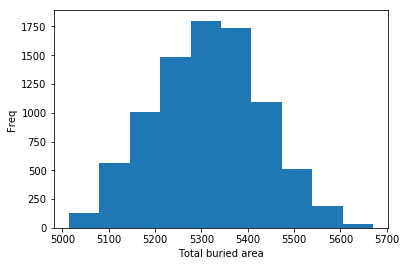

In [24]:
plt.xlabel('Total buried area')
plt.ylabel('Freq')
plt.hist(buriedAreas)


In [26]:
def calc_polarity(seq):
    '''
    {'A': 0, 'C': 1, 'D': 2, 'E': 3, 
    'F': 4, 'G': 5, 'H': 6, 'I': 7, 
    'K': 8, 'L': 9, 'M': 10, 'N': 11, 
    'P': 12, 'Q': 13, 'R': 14, 'S': 15, 
    'T': 16, 'V': 17, 'W': 18, 'Y': 19}
    '''
    dict={
        0:8.100,
        1:5.500,
        2:97.800,
        3:113.900,
        4:194.100,
        5:62.900,
        6:155.800,
        7:158.000,
        8:115.500,
        9:164.100,
        10:172.900,
        11:103.300,
        12:92.900,
        13:119.200,
        14:162.200,
        15:85.600,
        16:106.500,
        17:141.000,
        18:224.600,
        19:177.700
    }

In [45]:
def read_params(file):
    
    
    
    triple_to_single={
        'Ala':'A',
        'Arg':'R',
        'Asn':'N',
        'Asp':'D',
        'Cys':'C',
        'Gln':'Q',
        'Glu':'E',
        'Gly':'G',
        'His':'H',
        'Ile':'I',
        'Leu':'L',
        'Lys':'K',
        'Met':'M',
        'Phe':'F',
        'Pro':'P',
        'Ser':'S',
        'Thr':'T',
        'Trp':'W',
        'Tyr':'Y',
        'Val':'V'
    
    }
    
    single_to_encoder={'A': 0, 'C': 1, 'D': 2, 
                       'E': 3, 'F': 4, 'G': 5, 
                       'H': 6, 'I': 7, 'K': 8, 
                       'L': 9, 'M': 10, 'N': 11, 
                       'P': 12, 'Q': 13, 'R': 14, 
                       'S': 15, 'T': 16, 'V': 17, 
                       'W': 18, 'Y': 19}
    
    dictionary={}
    with open(file,'r') as input_file:
        for i in input_file.readlines():
            #print(i)
            if i.startswith(' '):
                continue
            elif i.startswith('\n'):
                pass
            else:
                aavalue=i.split(':')
                #print(aavalue)
                single=triple_to_single[aavalue[0]]
                encoder=single_to_encoder[single]
                dictionary.update({encoder:aavalue[1].strip()})
    return(dictionary)


def calc_feature(feature,seq):
    
    dict=read_params('../data/features/'+str(feature)+'.txt')
                

    feature=0.0
    for i in seq:
        feature+=float(dict[i])
    return(feature)

calc_feature('polarity',x_full_train[0])


392.59999999999997

In [54]:
import os
'''
Possible features by names of files in following directory
'''
os.listdir('../data/features')

['hydrophobicity-kyte.txt',
 'beta-sheet.txt',
 'bulkiness.txt',
 'beta-turn-Levitt.txt',
 'alpha-helix-Levitt.txt',
 'relative_mutability.txt',
 'recognition_factors.txt',
 'refractivity.txt',
 'hydrophobicity-abraham.txt',
 'average_flexibility.txt',
 'ratio_hetero_end-side.txt',
 'beta-turn.txt',
 'alpha-helix-Deleage.txt',
 'buried_residues.txt',
 'polarity-Zimmermann.txt',
 'aa_composition.txt',
 'number_of_codons.txt',
 'polarity.txt']

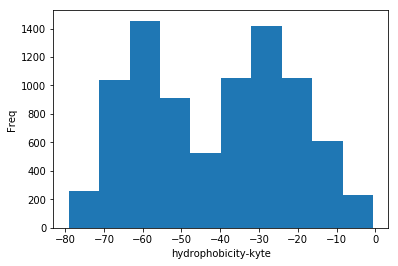

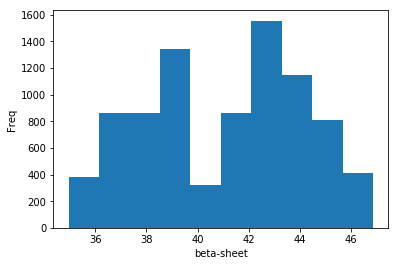

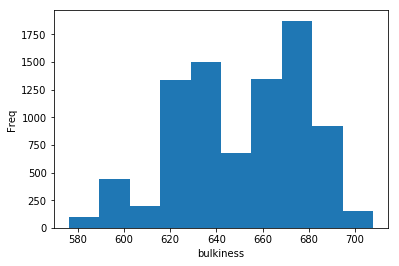

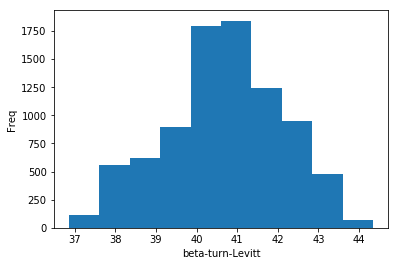

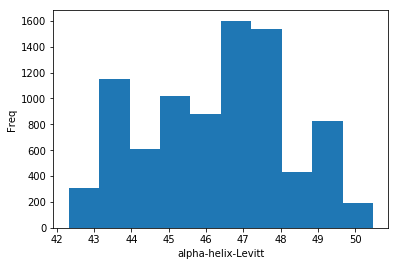

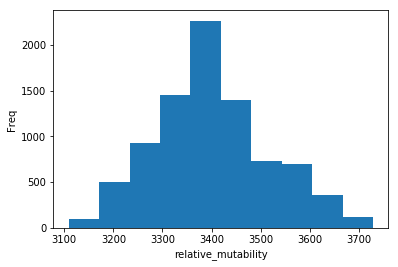

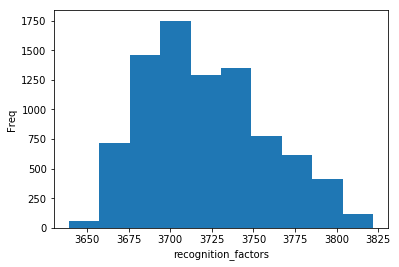

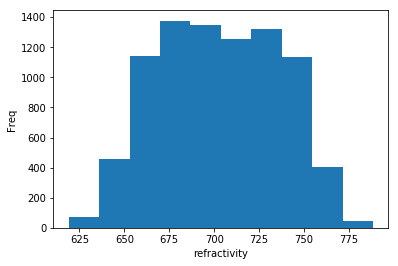

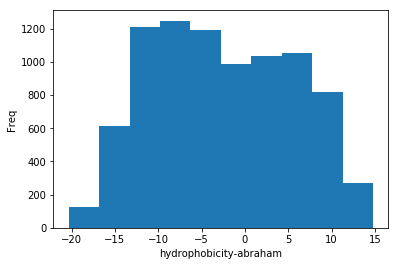

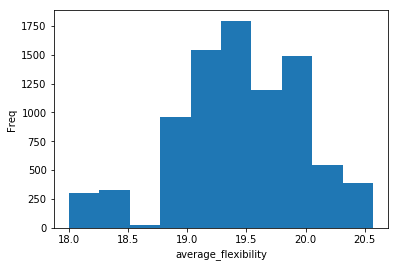

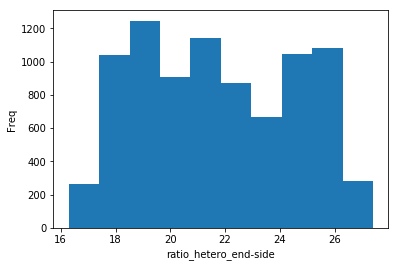

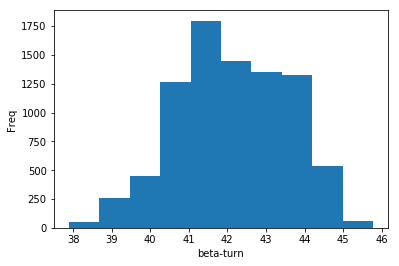

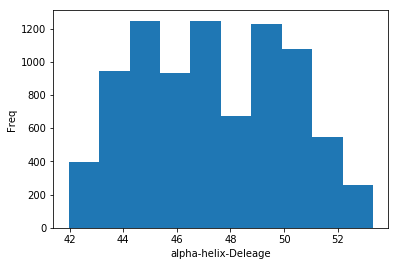

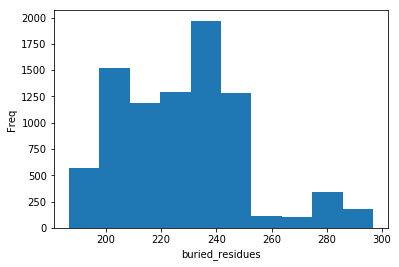

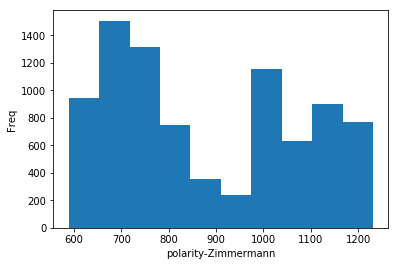

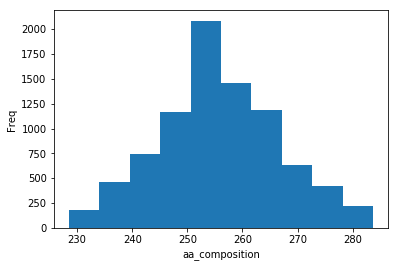

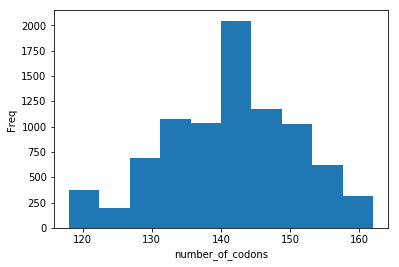

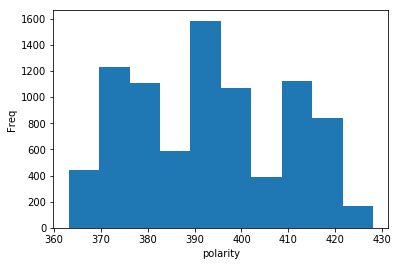

In [69]:
#feature_name='hydrophobicity-kyte'
feature_list=os.listdir('../data/features')
for i in feature_list:
    feature=[calc_feature(i.split('.')[0],x) for x in x_full_train]
    plt.xlabel(i.split('.')[0])
    plt.ylabel('Freq')
    plt.hist(feature)
    plt.show()